## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [76]:
import glob

import numpy as np
import scipy as sp
import scipy.io
from scipy import signal

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def RunPulseRateAlgorithm(data_fl, ref_fl):
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    ground_truth = scipy.io.loadmat(ref_fl)['BPM0'].reshape(-1)
#     print(np.shape(ground_truth))
    
    # Load data using LoadTroikaDataFile
    # ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    # Compute pulse rate estimates and estimation confidence.
    fs = 125
    window_length = 8*fs
    window_shift = 2*fs
    # Bandpass filter
    ppg  = bandpass(ppg, fs)
    accx = bandpass(accx, fs)
    accy = bandpass(accy, fs)
    accz = bandpass(accz, fs)

    # Magnitude of acceleration as 3D
    acc = np.sqrt(accx**2 + accy**2 + accz**2)

    bpm_predictions = []
    list_confidence = []

    for i in range(0, len(ppg)- window_length +1 , window_shift):
        ppg_current = ppg[i: i+ window_length]
        acc_current = acc[i: i+ window_length]

        # Apply Fourrier Transform
        ppg_freqs, ppg_ffts = fourrier_transformation(ppg_current, fs)
        acc_freqs, acc_ffts = fourrier_transformation(acc_current, fs)
        
        # Remove unwanted frequencies 
        ppg_ffts[ppg_freqs <= 40/60] = 0.0
        ppg_ffts[ppg_freqs >= 240/60] = 0.0
        acc_ffts[acc_freqs <= 40/60] = 0.0
        acc_ffts[acc_freqs >= 240/60] = 0.0


        # Get frequency that has the largerst FFT coefficient
        ppg_freq = ppg_freqs[np.argmax(ppg_ffts, axis=0)]  
        acc_freq = acc_freqs[np.argmax(acc_ffts, axis=0)]

        confidence = calculate_confidence(ppg_freqs, ppg_ffts, ppg_freq)
        
                
        k = 1
        while abs(ppg_freq - acc_freq) <= 0.01 and k <=3:                
            ppg_freq   = ppg_freqs[np.argsort(ppg_ffts, axis=0)[-k]]
            acc_freq = acc_freqs[np.argsort(acc_ffts, axis=0)[-k]]
            confidence = calculate_confidence(ppg_freqs, ppg_ffts, ppg_freq)
            
            k += 1
            

        bpm_predictions.append(ppg_freq * 60) # Convert to bpm from Hz
        list_confidence.append(confidence)

    errors = np.abs(np.subtract(bpm_predictions, ground_truth))



        # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
        #errors, confidence = np.ones(100), np.ones(100)  # Dummy placeholders. Remove
    return errors, list_confidence


def bandpass (signals, fs):
    """
    Filter pulse rate that will be restricted in bandpass 
    
    """
    # here we assumes pulse rate will be restricted between 40BPM (beats per minute) and 240BPM
    pass_band=(40/60.0, 240/60.0)
    b, a = sp.signal.butter(3, pass_band, btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signals)

def fourrier_transformation(signals, fs):   
    
    freqs = np.fft.rfftfreq(len(signals), 1/fs)
    fft = np.abs(np.fft.rfft(signals, len(signals)))
    return freqs, fft

def calculate_confidence(freq, fft, fulse_rate, windows = 1):
    
    """
    Inputs:
    freq: np.array Frequency bins
    fft: np.array  Magnitude of FFT 
    fulse_rate: the pulse rate
    windows: 
    Returns:
        confidence: float.
    """
    frequency_spectrum = (freq > fulse_rate - windows) & (freq <fulse_rate + windows)
    
    return np.sum(fft[frequency_spectrum])/np.sum(fft)
Evaluate()

20.500356187398459

In [71]:
data_fls, ref_fls = LoadTroikaDataset()

In [3]:
data_fls

['./datasets/troika/training_data/DATA_01_TYPE01.mat',
 './datasets/troika/training_data/DATA_02_TYPE02.mat',
 './datasets/troika/training_data/DATA_03_TYPE02.mat',
 './datasets/troika/training_data/DATA_04_TYPE01.mat',
 './datasets/troika/training_data/DATA_04_TYPE02.mat',
 './datasets/troika/training_data/DATA_05_TYPE02.mat',
 './datasets/troika/training_data/DATA_06_TYPE02.mat',
 './datasets/troika/training_data/DATA_07_TYPE02.mat',
 './datasets/troika/training_data/DATA_08_TYPE02.mat',
 './datasets/troika/training_data/DATA_10_TYPE02.mat',
 './datasets/troika/training_data/DATA_11_TYPE02.mat',
 './datasets/troika/training_data/DATA_12_TYPE02.mat']

In [4]:
ref_fls

['./datasets/troika/training_data/REF_01_TYPE01.mat',
 './datasets/troika/training_data/REF_02_TYPE02.mat',
 './datasets/troika/training_data/REF_03_TYPE02.mat',
 './datasets/troika/training_data/REF_04_TYPE01.mat',
 './datasets/troika/training_data/REF_04_TYPE02.mat',
 './datasets/troika/training_data/REF_05_TYPE02.mat',
 './datasets/troika/training_data/REF_06_TYPE02.mat',
 './datasets/troika/training_data/REF_07_TYPE02.mat',
 './datasets/troika/training_data/REF_08_TYPE02.mat',
 './datasets/troika/training_data/REF_10_TYPE02.mat',
 './datasets/troika/training_data/REF_11_TYPE02.mat',
 './datasets/troika/training_data/REF_12_TYPE02.mat']

In [5]:
data_fls, ref_fls = LoadTroikaDataset()
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

In [6]:
np.shape(ppg), np.shape(accx), np.shape(accy), np.shape(accz)

((37937,), (37937,), (37937,), (37937,))

In [8]:
import matplotlib.pyplot as plt

plt.plot(ppg)
plt.title('Center Title')
plt.title('Left Title', loc='left')
plt.title('Right Title', loc='right')
plt.show()

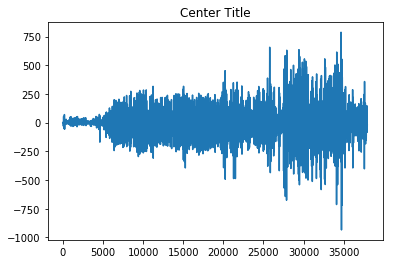

In [9]:
fs = 125 # Since the sampling rate was 125 Hz
ppg = bandpass (ppg, fs)

plt.plot(ppg)
plt.title('Center Title')
plt.show()

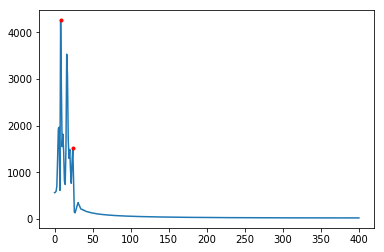

In [11]:
ppg_freq, ppg_fft = fourrier_transformation(ppg[200:1000], fs)
pks = sp.signal.find_peaks(ppg_fft, height=1000, distance=10)[0]

plt.plot(ppg_fft)
plt.plot(pks, ppg_fft[pks], 'r.')
plt.show()

In [12]:
np.mean((ppg_freq > 10) & (ppg_freq <15))

0.077306733167082295

In [13]:
np.sum(ppg_fft[(ppg_freq > 10) & (ppg_freq <12)])/np.sum(ppg_fft)

0.01738846052555941

In [23]:
ground_truth = scipy.io.loadmat(ref_fls[0])['BPM0'].reshape(-1)
np.shape(ground_truth)

(148,)

In [14]:
calculate_confidence(ppg_freq, ppg_fft, fulse_rate = 11 )

0.01738846052555941

In [16]:
acc

array([ 0.02203684,  0.02803522,  0.03435165, ...,  0.01121658,
        0.0104505 ,  0.00960517])

In [49]:
# Load data using LoadTroikaDataFile
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

# Compute pulse rate estimates and estimation confidence.
# Bandpass filter
ppg  = bandpass(ppg, fs)
accx = bandpass(accx, fs)
accy = bandpass(accy, fs)
accz = bandpass(accz, fs)

# Magnitude of acceleration as 3D
acc = np.sqrt(accx**2 + accy**2 + accz**2)

bpm_predictions = []
list_confidence = []
window_length = 1000
window_shift = 250
for i in range(0, len(ppg)- window_length, window_shift):
    ppg_current = ppg[i: i+ window_length]
    acc_current = acc[i: i+ window_length]

    # Apply Fourrier Transform
    ppg_freqs, ppg_ffts = fourrier_transformation(ppg_current, fs)
    acc_freqs, acc_ffts = fourrier_transformation(acc_current, fs)


    # Get frequency that has the largerst FFT coefficient
    ppg_freq = ppg_freqs[np.argmax(ppg_ffts, axis=0)]  
    acc_freq = acc_freqs[np.argmax(acc_ffts, axis=0)]

    confidence = calculate_confidence(ppg_freqs, ppg_ffts, ppg_freq)

    for k in range(1, len(ppg_fft)):
        if abs(ppg_freq - acc_freq) <= 0.1:
            break
        k_freq = ppg_freqs[np.argsort(ppg_fft, axis=0)[-k]]
        k_confidence = calculate_confidence(ppg_freqs, ppg_ffts, k_freq)
        
        if k_confidence > ppg_freq:
            ppg_freq, confidence = k_freq, k_confidence
            break
        

    bpm_predictions.append(ppg_freq * 60) # Convert to bpm (from Hz)
    list_confidence.append(confidence)

errors = np.abs(np.subtract(bpm_predictions, ground_truth))

In [50]:
len(ppg)
# errors

37937

In [69]:
# ppg_freqs

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

### Code Description
In this project, the algorithm runs on the TROIKA dataset to estimate the pulse rate associated with a confidence value by using the PPG sensor.

You can simply run Evaluate() function to get the mean absolute error. Moreover, you can also modify the following parameters:
+ RunPulseRateAlgorithm(data_fl, ref_fl) function: window_length, window_shift
+ bandpass (signals, fs) function: pass_band

### Data Description
The TROIKA data was recorded from subjects with ages between 18 and 35. During data recording, each subject ran on a treadmill with changing speeds. The PPG signal from channel one (wrist recorded, 125 Hz), three-axis acceleration signals(wrist recorded, 125 Hz), and ECG signals(chest recorded, 125 Hz) were used. 

### Algorithhm Description

The movement of the blood in the vessels is measured by an PPG sensor. We then estimate pulse rate from the PPG signal and a 3-axis accelerometer. In this algorithm, the signal data firstly goes through the bandpass filter to be restricted between 40BPM (beats per minute) and 240BPM. In combination with  the acelerometer data, the algorithm computes the largest/second largest or more FFT coefficients and choose the PPG frequency having the best estimate.


### Algorithm Performance: 
Algorithm performance is measured by using the mean absolute error in comparison with the ground truth (ECG). 

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 